In [2]:
import matplotlib.pyplot as plt
import snowflake.connector
import seaborn as sns
import pandas as pd
import numpy as np
import os

USER = os.getenv('SNOWFLAKE_USER')
PASSWORD = os.getenv('SNOWFLAKE_PASSWORD')
ACCOUNT = os.getenv('SNOWFLAKE_ACCOUNT')
WAREHOUSE = os.getenv('SNOWFLAKE_DEFAULT_WH')
DATABASE = os.getenv('SNOWFLAKE_DEFAULT_DB')
SCHEMA = 'CLEAN'
ROLE = os.getenv('SNOWFLAKE_ROLE')

# Conectar a Snowflake
conn = snowflake.connector.connect(
    user=USER,
    password=PASSWORD,
    account=ACCOUNT,
    warehouse=WAREHOUSE,
    database=DATABASE,
    schema=SCHEMA,
    role=ROLE
    )

COLOR = '#ff7300'

1.  Comportamiento de compra según día de la semana 
    - Analizar la distribución de órdenes por cada día (0 = domingo, 1 = lunes, etc.). 


In [3]:
# Ejecutar consulta para obtener datos de días y órdenes
result = conn.cursor().execute(f'SELECT * FROM DIM_DAY JOIN FACT_ORDERS USING (DAY_ID);')
df_days_n_orders = pd.DataFrame(result.fetchall(), columns=[desc[0] for desc in result.description])

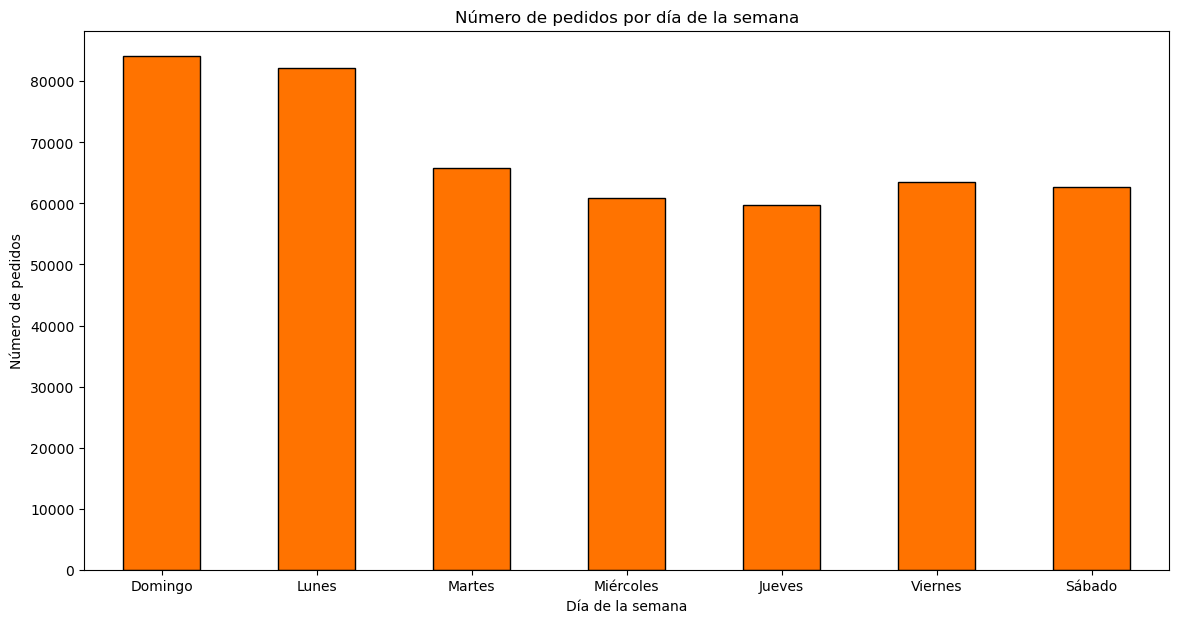

In [4]:
# Definir los nombres de los días de la semana
dias = {0: 'Domingo', 1: 'Lunes', 2: 'Martes', 3: 'Miércoles', 4: 'Jueves', 5: 'Viernes', 6: 'Sábado'}

# Agrupar el conteo de órdenes por día de la semana
df_order_dow = df_days_n_orders.groupby('ORDER_DOW')['ORDER_ID'].count()

# Asignar nombres de días al índice
df_order_dow.index = [dias[i] for i in df_order_dow.index]

# Graficar el número de órdenes por día de la semana
df_order_dow.plot(kind='bar', figsize=(14, 7), rot=0, color=COLOR, edgecolor='black')
plt.title('Número de pedidos por día de la semana')
plt.xlabel('Día de la semana')
plt.ylabel('Número de pedidos')
plt.show()

El comportamiento de compra según el día de la semana muestra que los días con mayor cantidad de pedidos son domingo y lunes, con cifras superiores a 80,000, lo que sugiere que los consumidores realizan más compras al inicio de la semana y durante el fin de semana. A partir del martes, la cantidad de pedidos disminuye, alcanzando su punto más bajo el jueves con aproximadamente 60,000 pedidos. Sin embargo, el número vuelve a aumentar ligeramente el viernes y sábado, indicando una tendencia de recuperación antes del fin de semana. Esto sugiere un patrón en el que las compras se concentran al inicio y al final de la semana.

2.  Comportamiento de compra según hora del día 
    - Evaluar la hora de las compras y ver la frecuencia por cada hora (0–23). 

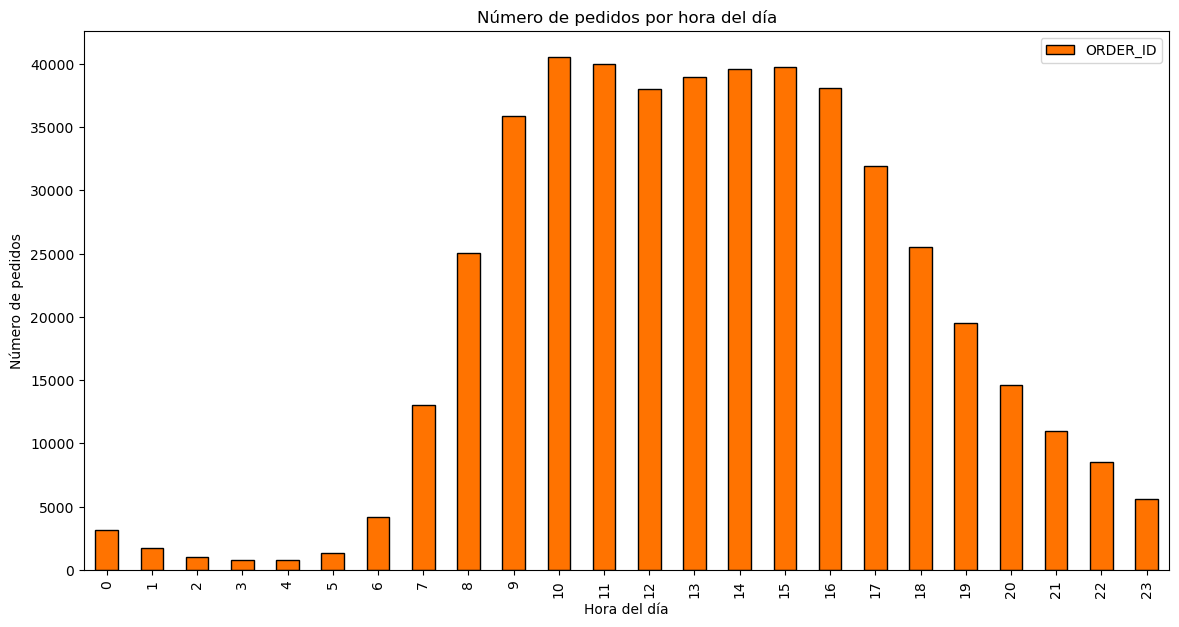

In [5]:
# Agrupar el conteo de órdenes por hora del día y graficar
df_days_n_orders.groupby('ORDER_HOUR_OF_DAY').agg({'ORDER_ID': 'count'}).plot(kind='bar', figsize=(14, 7), color=COLOR, edgecolor='black')
plt.title('Número de pedidos por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Número de pedidos')
plt.show()

El comportamiento de compra según la hora del día muestra un claro aumento en la cantidad de pedidos a partir de las 7 a.m., con un pico significativo entre las 9 a.m. y las 4 p.m., donde se mantiene en su punto más alto, superando los 40,000 pedidos en varias horas. A partir de las 5 p.m., el número de pedidos comienza a descender gradualmente, con una caída más pronunciada después de las 8 p.m. y niveles mínimos entre la medianoche y las 6 a.m. Este patrón indica que la mayoría de las compras ocurren durante las horas laborales y disminuyen considerablemente en la noche y madrugada.

3.  Comportamiento según hora del día y día de la semana 
    - Cruzar las dos variables para ver si hay días en que la compra por horas difiera 
del patrón general. 


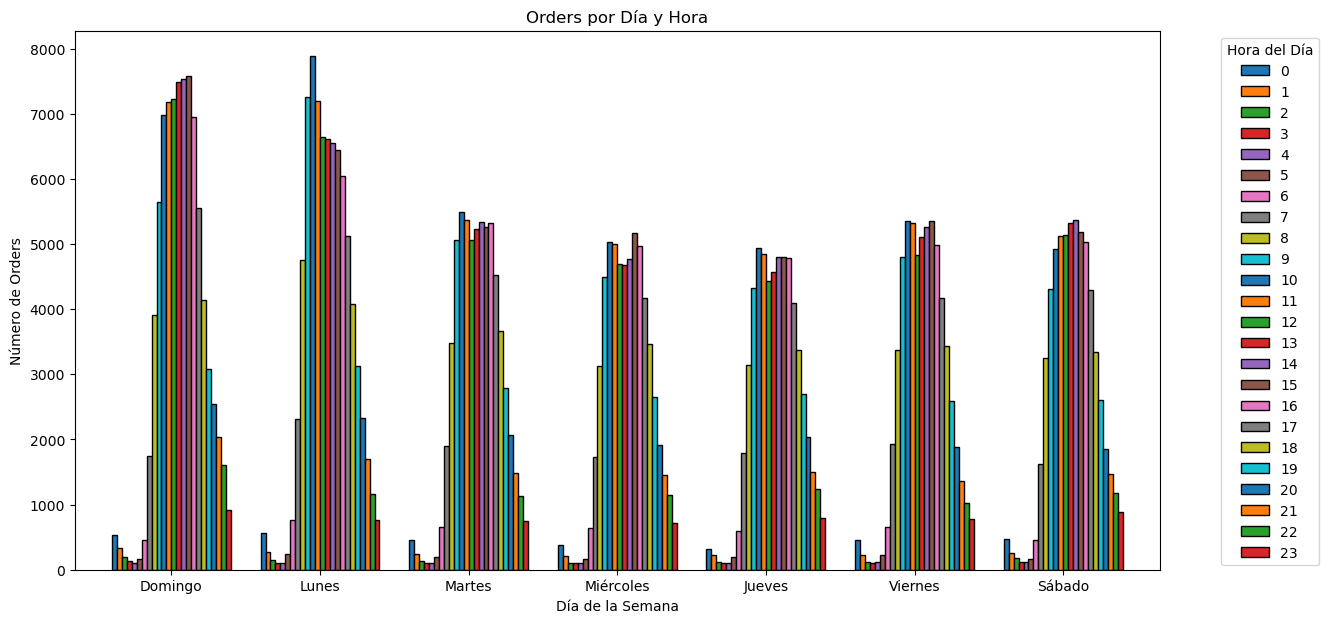

In [6]:
# Agrupar el conteo de órdenes por día de la semana y hora del día
order_counts = df_days_n_orders.groupby(['ORDER_DOW', 'ORDER_HOUR_OF_DAY'])['ORDER_ID'].count()

# Asignar nombres de días al índice
order_counts.index = order_counts.index.set_levels([
    [dias[i] for i in order_counts.index.levels[0]], 
    order_counts.index.levels[1]
])

# Desapilar el índice de horas del día
order_counts_unstacked = order_counts.unstack(level='ORDER_HOUR_OF_DAY')

# Graficar el número de órdenes por día y hora
order_counts_unstacked.plot(kind='bar', stacked=False, figsize=(14, 7), width=0.8, edgecolor='black', rot=0)

plt.title('Orders por Día y Hora')
plt.xlabel('Día de la Semana')
plt.ylabel('Número de Orders')
plt.legend(title='Hora del Día', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

El análisis del comportamiento de compras según la hora del día y el día de la semana muestra que el patrón general se mantiene relativamente constante en todos los días, con picos de pedidos entre las 9 a.m. y las 4 p.m. Sin embargo, se observan algunas diferencias: los domingos y lunes presentan los volúmenes más altos de pedidos en la mayoría de las horas, con un pico más pronunciado en la mañana. Entre martes y jueves, la actividad es más moderada, mientras que los viernes y sábados muestran un leve repunte en horas de la tarde, lo que sugiere una posible preparación para el fin de semana.

4.  Distribución de las órdenes hechas por los clientes 
    - ¿Hay clientes que hacen más órdenes que otros? ¿Cuántas órdenes hace un 
cliente en promedio? 


In [7]:
# Ejecutar consulta para obtener datos de órdenes
result = conn.cursor().execute(f'SELECT * FROM FACT_ORDERS')
df_orders = pd.DataFrame(result.fetchall(), columns=[desc[0] for desc in result.description])

Promedio de órdenes por usuario: 3.042181952145938
Límite superior: 8.5
Límite superior extremo: 13.0
Número de outliers por encima del límite superior: 8479
Número de outliers por encima del límite superior extremo: 1724


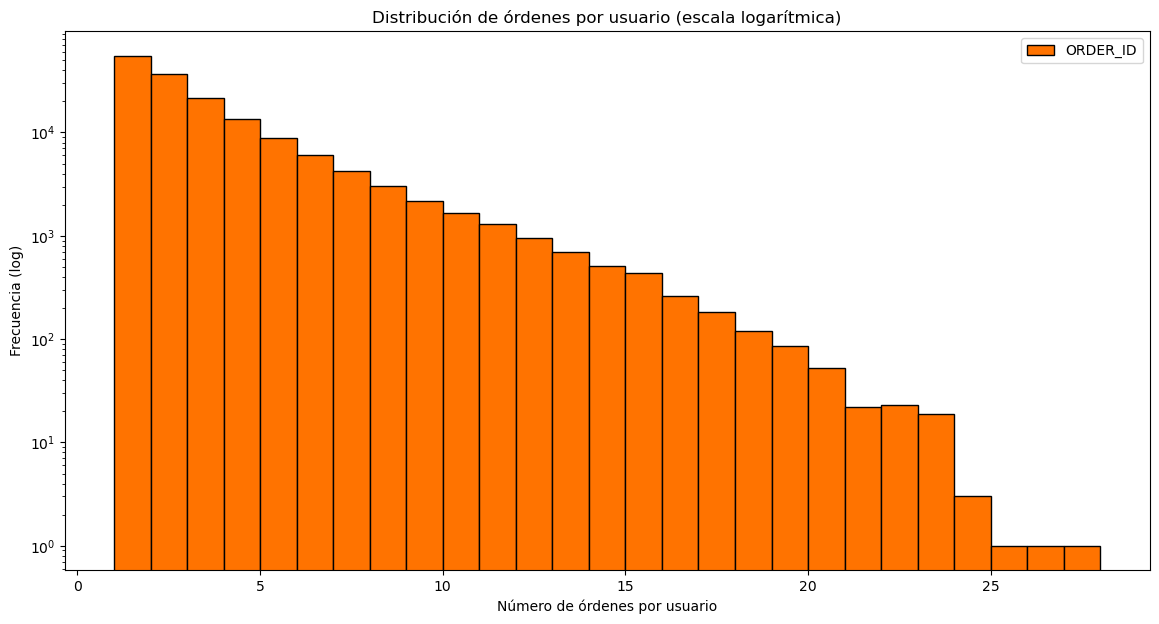

In [8]:
# Calcular el número de órdenes por usuario
orders_per_user = df_orders.groupby('USER_ID').agg({'ORDER_ID': 'count'})

# Calcular el rango intercuartil (IQR) y los límites para identificar outliers
Q1 = orders_per_user['ORDER_ID'].quantile(0.25)
Q3 = orders_per_user['ORDER_ID'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR
upper_upper_bound = Q3 + 3 * IQR

# Identificar outliers
outliers_upper = orders_per_user[(orders_per_user['ORDER_ID'] > upper_bound)]
outliers_upper_upper = orders_per_user[(orders_per_user['ORDER_ID'] > upper_upper_bound)]

# Imprimir estadísticas generales
print(f"Promedio de órdenes por usuario: {orders_per_user['ORDER_ID'].mean()}")
print(f"Límite superior: {upper_bound}")
print(f"Límite superior extremo: {upper_upper_bound}")
print(f"Número de outliers por encima del límite superior: {len(outliers_upper)}")
print(f"Número de outliers por encima del límite superior extremo: {len(outliers_upper_upper)}")

# Graficar la distribución de órdenes por usuario
orders_per_user.plot(kind='hist', figsize=(14, 7), color=COLOR, edgecolor='black', bins=range(1, int(orders_per_user.max().iloc[0])+1))
plt.yscale('log')
plt.xlabel('Número de órdenes por usuario')
plt.ylabel('Frecuencia (log)')
plt.title('Distribución de órdenes por usuario (escala logarítmica)')
plt.show()

La distribución de órdenes por usuario muestra una variabilidad significativa, con un promedio de aproximadamente 3.04 órdenes por cliente, un límite superior de 8.5 y un límite extremo de 13.0. La mayoría de los usuarios realiza entre 1 y 5 órdenes, pero hay 8,479 usuarios considerados outliers por encima del límite superior, y 1,724 por encima del límite extremo, lo que indica que algunos clientes hacen muchas más órdenes que otros. Esta caída gradual en la frecuencia de órdenes sugiere que, aunque hay un pequeño grupo que realiza un número elevado de compras, la gran mayoría tiende a hacer pocas, evidenciando un comportamiento de compra concentrado en unos pocos clientes.

5.  Top 20 productos más frecuentes 
    - Contar la frecuencia con que aparecen los productos en las órdenes. 


In [9]:
# Ejecutar consulta para obtener datos de productos y órdenes
result = conn.cursor().execute(f'SELECT * FROM DIM_PRODUCTS JOIN FACT_ORDER_PRODUCTS USING (PRODUCT_ID) JOIN FACT_ORDERS USING (ORDER_ID);')
df_orders_n_products = pd.DataFrame(result.fetchall(), columns=[desc[0] for desc in result.description])

| PRODUCT_NAME             |   ORDER_ID |
|:-------------------------|-----------:|
| banana                   |      66050 |
| bag of organic bananas   |      53297 |
| organic strawberries     |      37039 |
| organic baby spinach     |      33971 |
| organic hass avocado     |      29773 |
| organic avocado          |      24689 |
| large lemon              |      21495 |
| strawberries             |      20018 |
| limes                    |      19690 |
| organic whole milk       |      19600 |
| organic raspberries      |      19197 |
| organic yellow onion     |      15898 |
| organic garlic           |      15292 |
| organic zucchini         |      14584 |
| organic blueberries      |      13879 |
| cucumber kirby           |      13675 |
| organic fuji apple       |      12544 |
| organic lemon            |      12232 |
| apple honeycrisp organic |      11993 |
| organic grape tomatoes   |      11781 |


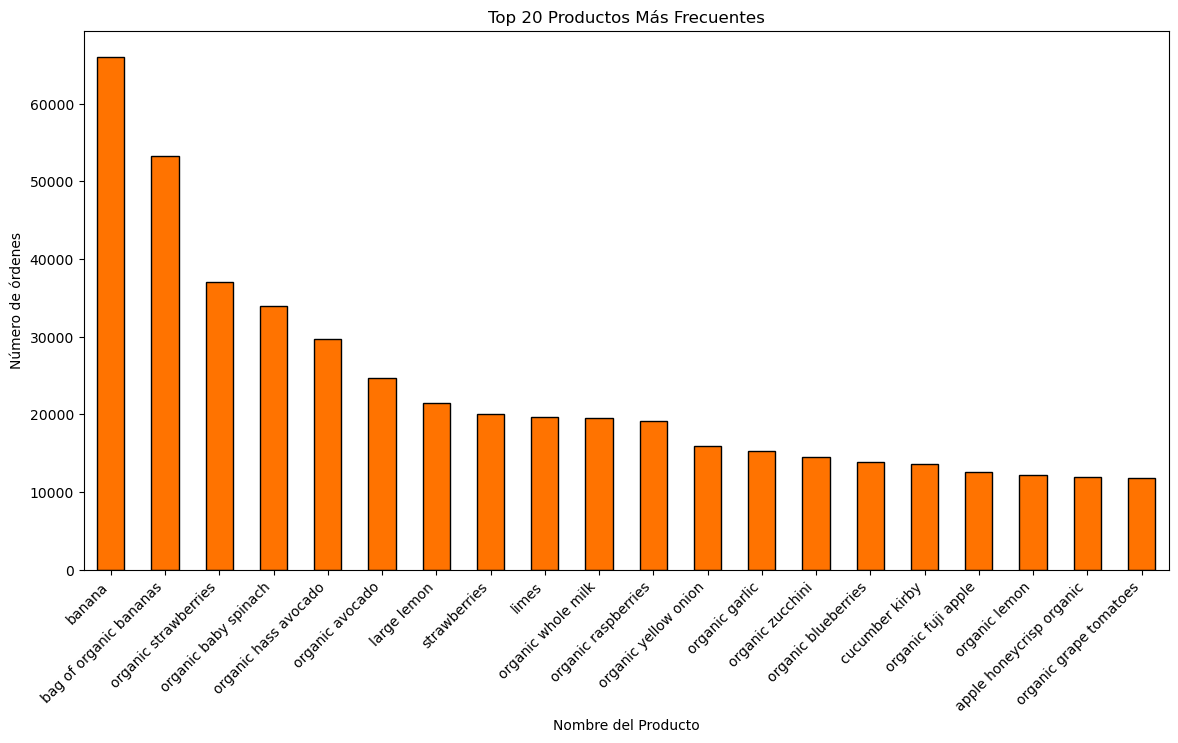

In [10]:
# Obtener los 20 productos más frecuentes en las órdenes
top_20_products = df_orders_n_products.groupby('PRODUCT_NAME')['ORDER_ID'].count().sort_values(ascending=False).head(20)
print(top_20_products.to_markdown())

# Graficar los 20 productos más frecuentes
top_20_products.plot(kind='bar', figsize=(14, 7), color=COLOR, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Productos Más Frecuentes')
plt.xlabel('Nombre del Producto')
plt.ylabel('Número de órdenes')
plt.show()


Los 20 productos más frecuentes en las órdenes revelan que las bananas son el producto más popular, con 66,050 apariciones, seguidas por la bolsa de bananas orgánicas con 53,297 y las fresas orgánicas con 37,039. Otros productos destacados incluyen espinacas baby orgánicas (33,971), aguacate hass orgánico (29,773) y aguacate orgánico (24,689). La lista continúa con limones grandes (21,495), fresas (20,018) y limas (19,690), entre otros. Esta tendencia sugiere una preferencia notable por frutas y verduras frescas entre los clientes.

6.  ¿Cuántos artículos se compran generalmente en un pedido? 
    - Distribución de la cantidad de artículos por orden. 



Promedio de productos por orden: 10.098983215049127
Mediana: 8.0
Moda: 5
Máximo: 127



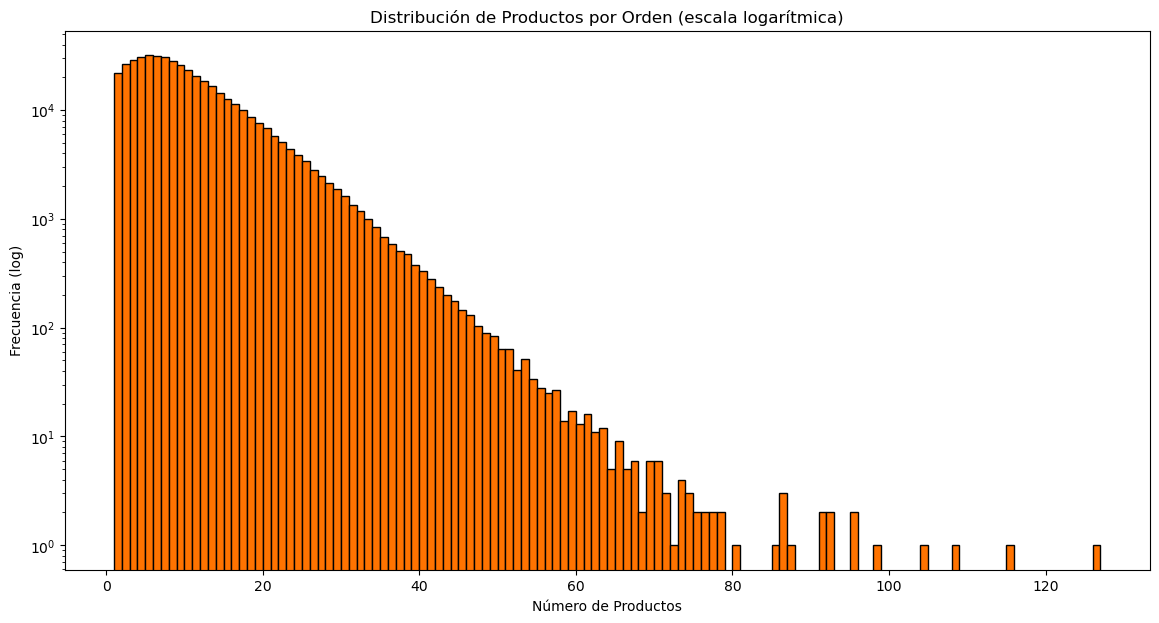

In [11]:
# Calcular el número de productos por orden
items_per_order = df_orders_n_products.groupby('ORDER_ID')['PRODUCT_NAME'].count()

# Graficar la distribución de productos por orden
items_per_order.hist(bins=range(1, int(items_per_order.max())+1), figsize=(14, 7), color=COLOR, edgecolor='black')
plt.yscale('log')
plt.title('Distribución de Productos por Orden (escala logarítmica)')
plt.xlabel('Número de Productos')
plt.ylabel('Frecuencia (log)')
plt.grid(False)

# Imprimir estadísticas generales
print(f"""
Promedio de productos por orden: {items_per_order.mean()}
Mediana: {items_per_order.median()}
Moda: {items_per_order.mode().values[0]}
Máximo: {items_per_order.max()}
""")

En promedio, los pedidos contienen aproximadamente 10.1 artículos, con una mediana de 8 y una moda de 5, lo que indica que la mayoría de los clientes suelen comprar entre 5 y 8 productos por orden. Sin embargo, hay un máximo de 127 artículos en un solo pedido, lo que sugiere que, aunque la mayoría de las compras son relativamente pequeñas, existen casos de pedidos significativamente más grandes. La distribución muestra una caída pronunciada en la frecuencia de pedidos a medida que aumenta el número de productos, lo que refuerza esta tendencia general.

7.  Top 20 artículos que se vuelven a pedir con más frecuencia 
    - Productos con mayor índice de reorder. 


| PRODUCT_NAME             |   REORDERED |
|:-------------------------|------------:|
| banana                   |       55763 |
| bag of organic bananas   |       44450 |
| organic strawberries     |       28639 |
| organic baby spinach     |       26233 |
| organic hass avocado     |       23629 |
| organic avocado          |       18743 |
| organic whole milk       |       16251 |
| large lemon              |       15044 |
| organic raspberries      |       14748 |
| strawberries             |       13945 |
| limes                    |       13327 |
| organic yellow onion     |       11145 |
| organic garlic           |       10411 |
| organic zucchini         |       10076 |
| cucumber kirby           |        9538 |
| organic fuji apple       |        8989 |
| apple honeycrisp organic |        8836 |
| organic blueberries      |        8799 |
| organic lemon            |        8412 |
| organic half & half      |        8389 |


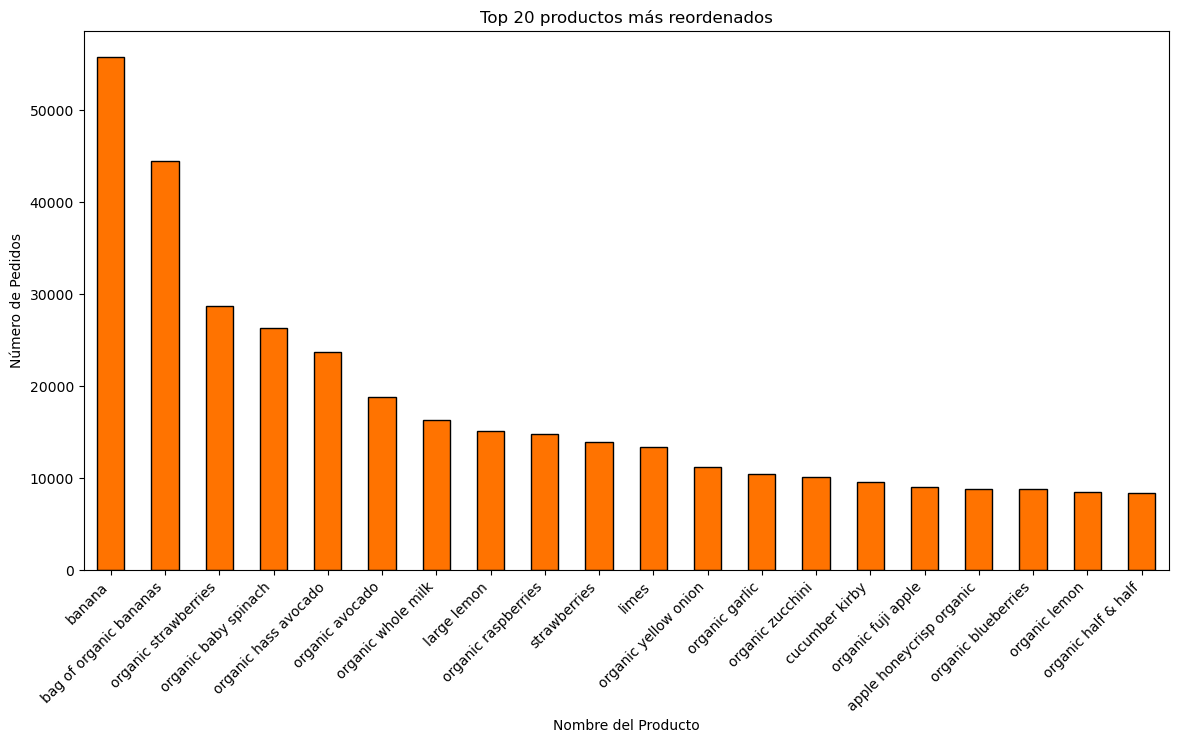

In [12]:
# Obtener los 20 productos más reordenados
top_20_reordered = df_orders_n_products[df_orders_n_products['REORDERED']].groupby('PRODUCT_NAME')['REORDERED'].count().sort_values(ascending=False).head(20)
print(top_20_reordered.to_markdown())

# Graficar los 20 productos más reordenados
top_20_reordered.plot(kind='bar', figsize=(14, 7), color=COLOR, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 productos más reordenados')
plt.xlabel('Nombre del Producto')
plt.ylabel('Número de Pedidos')
plt.show()

Los 20 productos que se vuelven a pedir con mayor frecuencia están encabezados por las bananas, con 55,763 reordenes, seguidas por la bolsa de bananas orgánicas con 44,450 y las fresas orgánicas con 28,639. Otros productos notables incluyen espinacas baby orgánicas (26,233), aguacate hass orgánico (23,629) y aguacate orgánico (18,743). La tendencia muestra que los consumidores tienden a reordenar frutas y verduras frescas con regularidad, lo que refleja una preferencia por estos productos en su dieta habitual.

8.  Proporción de pedidos que se vuelven a pedir para cada producto 
    - Para cada producto, calcular cuántas veces es “reordenado” respecto al total de 
pedidos del mismo. 


In [13]:
# Ejecutar consulta para obtener datos de productos y órdenes
result = conn.cursor().execute(f'SELECT * FROM DIM_PRODUCTS JOIN FACT_ORDER_PRODUCTS USING (PRODUCT_ID);')
df_products_orders = pd.DataFrame(result.fetchall(), columns=[desc[0] for desc in result.description])

|       | PRODUCT_NAME                                     |   total_orders |   reordered_orders |   reorder_rate |
|------:|:-------------------------------------------------|---------------:|-------------------:|---------------:|
|  8959 | coffee flavor yogurt                             |             17 |                 17 |              1 |
| 24091 | natural fat free cheddar shredded cheese         |             16 |                 16 |              1 |
| 39079 | super premium chocolate ice cream                |             16 |                 16 |              1 |
| 38853 | sugar land sweet tea                             |             14 |                 14 |              1 |
| 13869 | free ride hibiscus brew craft brewed kombucha    |             13 |                 13 |              1 |
|   133 | 100% colombia supremo medium                     |             12 |                 12 |              1 |
| 19368 | jumbo ranch sunflower seeds                      |            

<Figure size 1400x700 with 0 Axes>

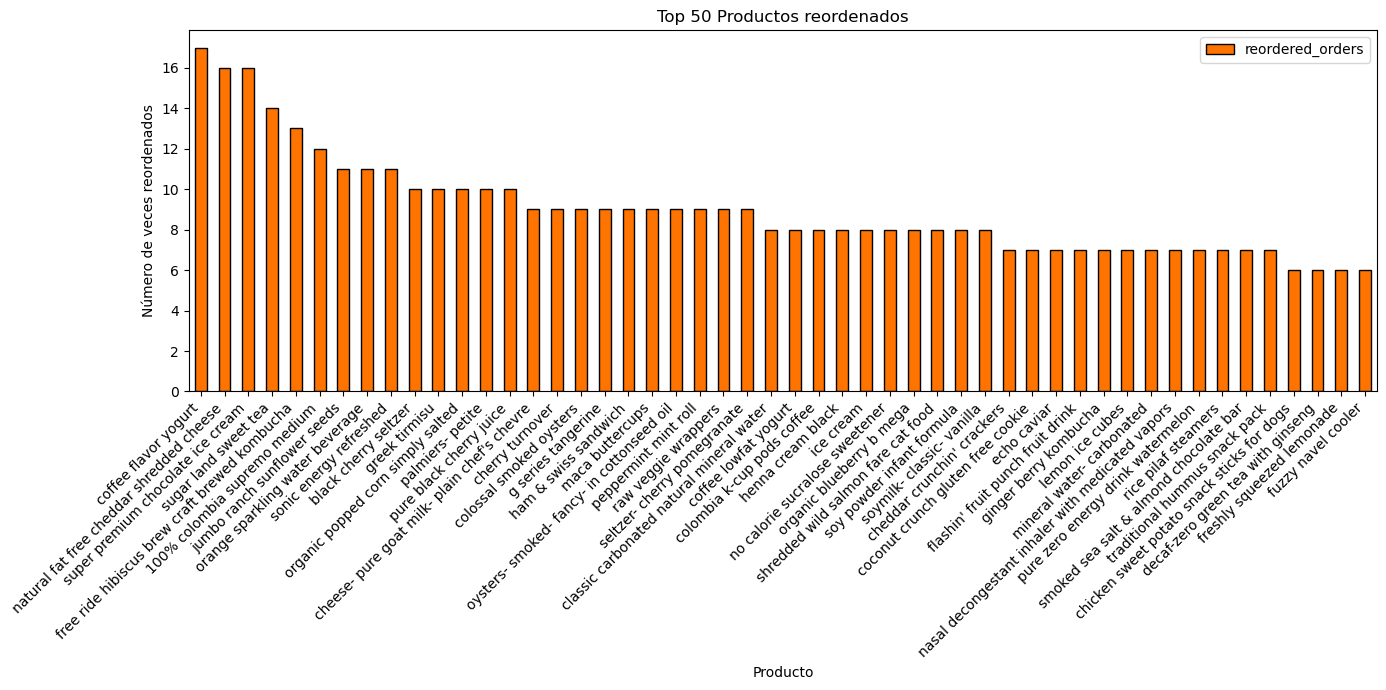

In [14]:
# Agrupar por producto y orden para obtener si fue reordenado
df_product_order = df_products_orders.groupby(['PRODUCT_NAME', 'ORDER_ID'])['REORDERED'].max().reset_index(name='IS_REORDERED')

# Calcular la proporción de reorden por producto
reorder_prop = df_product_order.groupby('PRODUCT_NAME').agg(total_orders=('IS_REORDERED', 'count'), reordered_orders=('IS_REORDERED', 'sum')).reset_index()

# Calcular la tasa de reorden y ordenar los productos
reorder_prop['reorder_rate'] = reorder_prop['reordered_orders'] / reorder_prop['total_orders']
reorder_prop = reorder_prop.sort_values(['reorder_rate', 'reordered_orders'], ascending=False).head(50)
print(reorder_prop.to_markdown())

# Graficar los productos más reordenados
plt.figure(figsize=(14, 7))
reorder_prop.plot(kind='bar', figsize=(14, 7), edgecolor='black', color=COLOR, x='PRODUCT_NAME', y='reordered_orders')

plt.xticks(rotation=45, ha='right')
plt.title('Top 50 Productos reordenados')
plt.ylabel('Número de veces reordenados')
plt.xlabel('Producto')
plt.tight_layout()
plt.show()

La proporción de pedidos que se vuelven a pedir es excepcionalmente alta para varios productos, con muchos alcanzando un 100% de reordenes. Por ejemplo, productos como el yogurt de sabor a café, el queso cheddar natural y el helado de chocolate premium han sido reordenados en su totalidad, con 16 o más pedidos cada uno. Otros productos, como el té dulce y el kombucha, también muestran tasas perfectas de reorden. Esta tendencia indica que estos artículos son altamente valorados por los clientes, lo que sugiere una lealtad significativa hacia ellos en sus decisiones de compra.

9.  Proporción de productos pedidos que se vuelven a pedir para cada cliente 
    - Cuántos productos vuelven a pedir los clientes en relación a la cantidad total de 
productos comprados por cliente. 


|   USER_ID |   total_products |   reordered_products |   proporcion_reorden |
|----------:|-----------------:|---------------------:|---------------------:|
|     75124 |              239 |                  239 |                    1 |
|    179684 |               78 |                   78 |                    1 |
|     39245 |               76 |                   76 |                    1 |
|    186894 |               65 |                   65 |                    1 |
|     11970 |               59 |                   59 |                    1 |
|     88822 |               58 |                   58 |                    1 |
|     81466 |               56 |                   56 |                    1 |
|     74034 |               54 |                   54 |                    1 |
|    183159 |               54 |                   54 |                    1 |
|     13548 |               52 |                   52 |                    1 |
|     82414 |               51 |                   5

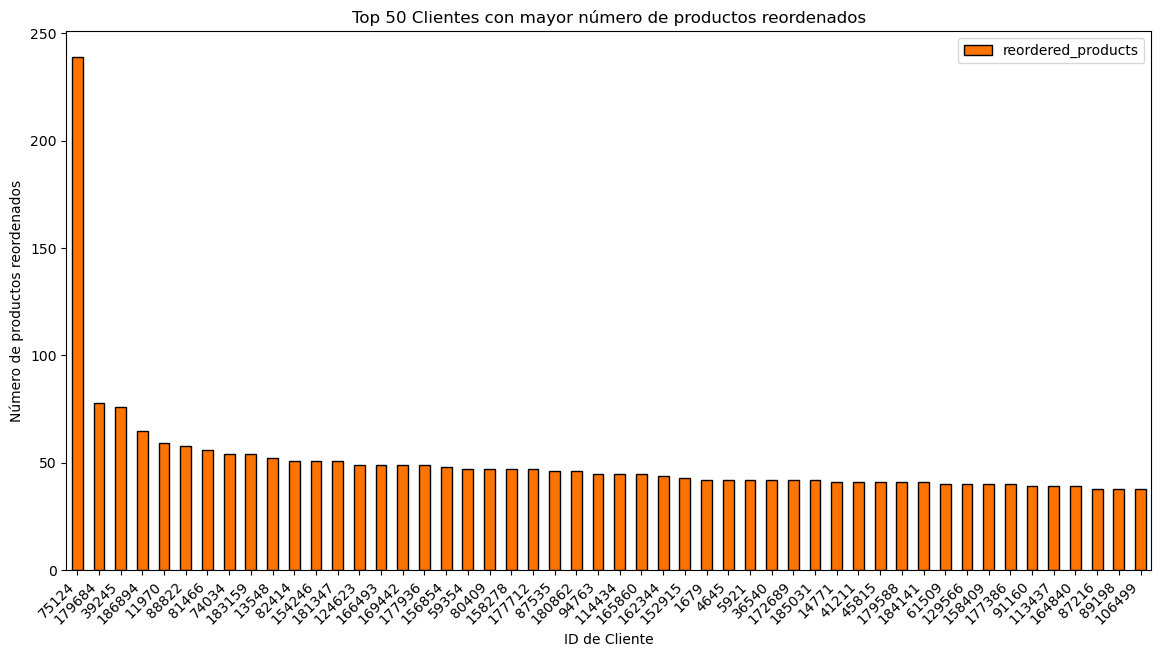

In [17]:
# Calcular la proporción de productos reordenados por cliente
customer_reorder = df_orders_n_products.groupby('USER_ID').agg(total_products=('REORDERED', 'count'), reordered_products=('REORDERED', 'sum')).reset_index()

# Calcular la proporción de reorden por cliente
customer_reorder['proporcion_reorden'] = customer_reorder['reordered_products'] / customer_reorder['total_products']

# Ordenar los clientes por proporción de reorden y número de productos reordenados
customer_reorder = customer_reorder.sort_values(['proporcion_reorden', 'reordered_products'], ascending=False).head(50)
print(customer_reorder.to_markdown(index=False))

# Graficar los 50 clientes con mayor número de productos reordenados
customer_reorder.plot(kind='bar', x='USER_ID', y='reordered_products', figsize=(14, 7), color=COLOR, edgecolor='black')

plt.title('Top 50 Clientes con mayor número de productos reordenados')
plt.ylabel('Número de productos reordenados')
plt.xlabel('ID de Cliente')
plt.xticks(rotation=45, ha='right')
plt.show()

La proporción de productos que los clientes vuelven a pedir es notablemente alta entre los principales usuarios, con varios alcanzando un 100% de reordenes, lo que indica que todos los productos comprados fueron solicitados nuevamente. Por ejemplo, el cliente con ID 75124 realizó 239 compras, todas de las cuales fueron reordenadas. Otros usuarios, como los IDs 179684 y 39245, también muestran tasas perfectas de reorden.

Sin embargo, se observan outliers en el gráfico, donde algunos clientes con un número considerablemente menor de productos reordenados, como aquellos que han realizado pocas compras y no han reordenado en absoluto. Esto sugiere variaciones en la lealtad y comportamiento de compra entre los diferentes consumidores, mostrando que, mientras algunos son muy leales y reordenan todo, otros pueden no estar tan comprometidos con los productos adquiridos. Esta diversidad en el comportamiento de compra resalta la importancia de analizar las preferencias individuales de los clientes.

10. Top 20 artículos que la gente pone primero en el carrito 
    - Orden por la columna add_to_cart_order = 1 para identificar los productos 
más comunes en primera posición.

PRODUCT_NAME
banana                         15562
bag of organic bananas         11026
organic whole milk              4363
organic strawberries            3946
organic hass avocado            3390
organic baby spinach            3336
organic avocado                 3044
spring water                    2336
strawberries                    2308
organic raspberries             2024
sparkling water grapefruit      1914
organic half & half             1797
large lemon                     1737
soda                            1733
organic reduced fat milk        1397
limes                           1370
hass avocados                   1340
organic reduced fat 2% milk     1310
half & half                     1309
raspberries                     1246
Name: ADD_TO_CART_ORDER, dtype: int64


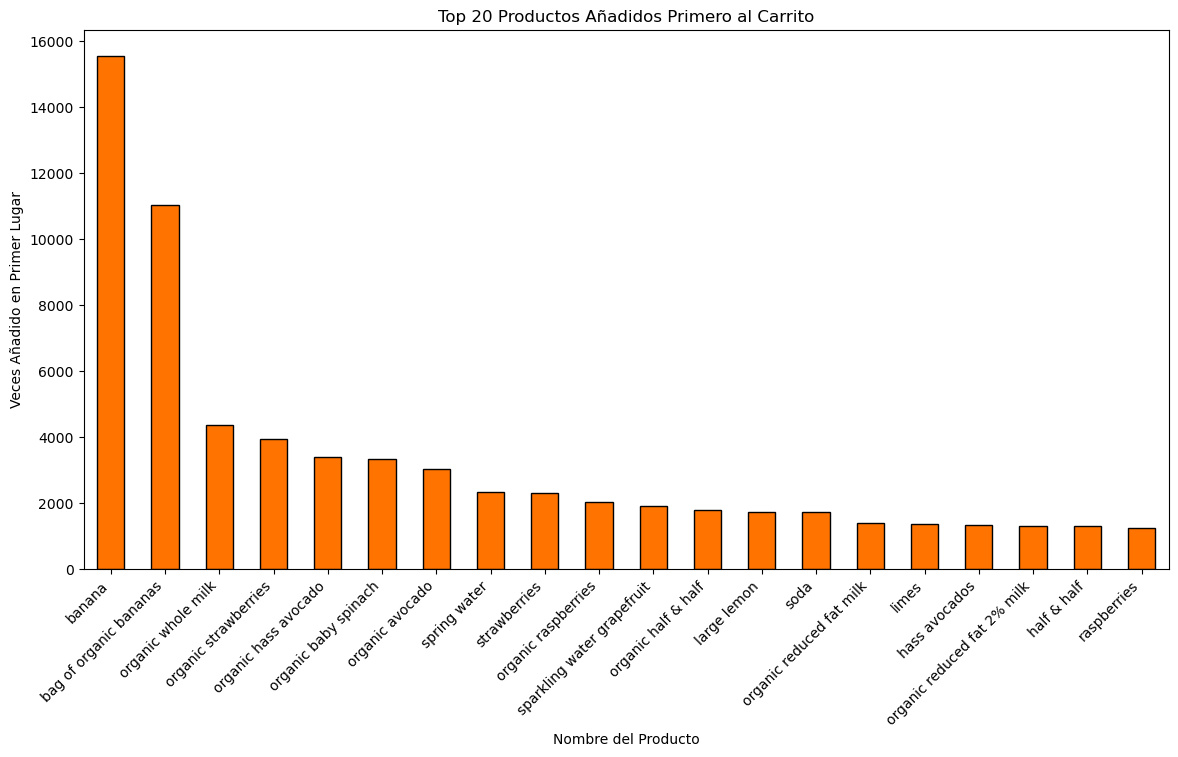

In [16]:
# Filtrar productos que fueron añadidos primero al carrito
df_first_in_cart = df_products_orders[df_products_orders['ADD_TO_CART_ORDER'] == 1]

# Obtener los 20 productos más comunes añadidos primero al carrito
top_20_first_added = df_first_in_cart.groupby('PRODUCT_NAME')['ADD_TO_CART_ORDER'].count().sort_values(ascending=False).head(20)

# Imprimir los 20 productos más comunes añadidos primero al carrito
print(top_20_first_added)

# Graficar los 20 productos más comunes añadidos primero al carrito
top_20_first_added.plot(kind='bar', figsize=(14, 7), color=COLOR, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Productos Añadidos Primero al Carrito')
plt.xlabel('Nombre del Producto')
plt.ylabel('Veces Añadido en Primer Lugar')
plt.show()